In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../Model')
from ResTCN import TCNSE
from dataset.dataset import NIDSDataset
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from scipy.ndimage import gaussian_filter1d
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from matplotlib.gridspec import GridSpec


In [2]:
model = TCNSE()

c:\Software\Python\lib\site-packages\torch\nn\utils\weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [4]:
model.load_state_dict(torch.load('./save/model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
dataset = NIDSDataset("/root/autodl-tmp/test_20_features.csv")
dataloader = DataLoader(dataset, batch_size=4096, shuffle=False, num_workers=10)

In [6]:
model.to(device)
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    all_labels = []
    all_predictions = []
    for data in dataloader:
        features, labels = data
        features = features.unsqueeze(1)
        labels = labels.float()
        features, labels = features.to(device), labels.to(device)
        outputs = model(features).squeeze()
        preds = torch.sigmoid(outputs) >= 0.5
        predicted = preds.long()

        total += labels.size(0)
        correct += (predicted == labels.long()).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    tnr = tn / (fp + tn) if (fp + tn) != 0 else 0
    auc_score = roc_auc_score(all_labels, all_predictions)


In [7]:
print(auc_score)

0.9779083194655612


In [12]:
print(f"Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, FPR: {fpr:.2f}, TNR: {tnr:.2f}")

Accuracy: 98.46%, Precision: 0.99, Recall: 0.99, F1: 0.99, FPR: 0.03, TNR: 0.97


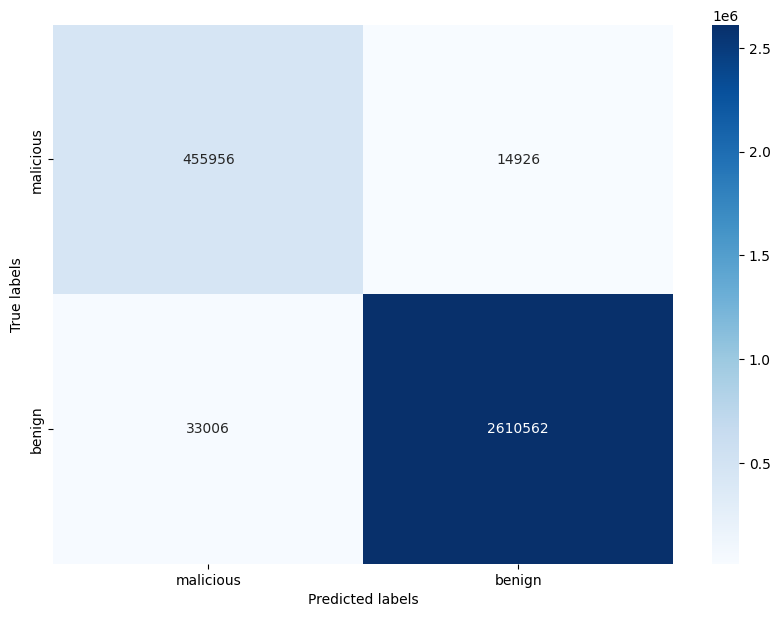

In [18]:
# 用 seaborn 绘制混淆矩阵
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['malicious', 'benign'], yticklabels=['malicious', 'benign'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [3]:
data = pd.read_csv("/root/autodl-tmp/data/test_20_features.csv")

In [ ]:
attack_types = ['DDoS attack', 'DoS attack', 'Botnet', 'Infilteration', 'Brute-force', 'Web attack']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, attack in enumerate(attack_types):
    print(f'Attack type: {attack}')
    data_attack = data[data['label'] == attack]
    data_benign = data[data['label'] == 'Benign']
    data_test = pd.concat([data_attack, data_benign]).reset_index(drop=True)
    
    X_test = data_test.drop('label', axis=1)
    y_test = data_test['label']
    
    y_test_binary = y_test.apply(lambda x: 0 if x == 'Benign' else 1)
    
    all_labels = []
    all_predictions = []
    all_scores = []
    correct = 0
    total = 0
    for i in range(0, len(X_test), 4096):
        X_test_batch = torch.tensor(X_test[i:i+4096].values).float().unsqueeze(1).to(device)
        y_test_batch = torch.tensor(y_test_binary[i:i+4096].values).float().to(device)
        y_pred_batch = model(X_test_batch)
        y_scores = torch.sigmoid(y_pred_batch).cpu().detach().numpy().flatten()
        
        y_scores_attack = 1 - y_scores
        
        predicted = (y_scores_attack >= 0.5).astype(int)
        
        all_labels.extend(y_test_batch.cpu().numpy())
        all_predictions.extend(predicted)
        all_scores.extend(y_scores_attack)
        total += y_test_batch.size(0)
        correct += (predicted == y_test_batch.cpu().numpy()).sum()
    
    accuracy = 100 * correct / total
    tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()
    print(f'confunsion matrix（{attack}）：\n[[{tn} {fp}]\n [{fn} {tp}]]\n')
    
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    
    fnr = 1 - recall
    
    fpr, tpr, _ = roc_curve(all_labels, all_scores, pos_label=1)
    auc_score = auc(fpr, tpr)
    print(f'{attack}: Accuracy: {accuracy:.2f}%, TPR: {recall:.2f}, FNR: {fnr:.2f}, AUC: {auc_score:.2f}\n')
    
    ax = axes[idx]
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_score:.2f}')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve ({attack})')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [9]:
# get data from the tfevent file
def extract_scalar_from_event(file_path, tag):
    ea = EventAccumulator(file_path)
    ea.Reload()
    events = ea.Scalars(tag)
    steps = [event.step for event in events]
    values = [event.value for event in events]
    return steps, values


# get the last step data from the tfevent file
def get_last_step_data(log_dir, tag):
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    events = event_acc.Scalars(tag)

    if events:
        last_event = events[-1]
        return last_event.step, last_event.value
    else:
        return None, None


In [10]:
# 对比不同时间卷积块结构下个指标
#  1. 128 64 32
#  2. 256 228 64
#  3  128 64 32 16
#  4. 256 128 64 32

tfevents1 = "./metrics/128_64_32.tfevents"
tfevents2 = "./metrics/256_128_64.tfevents"
tfevents3 = "./metrics/128_64_32_16.tfevents"
tfevents4 = "./metrics/256_128_64_32.tfevents"

steps_train_loss1, train_loss1 = extract_scalar_from_event(tfevents1, "training loss")
steps_test_loss1, test_loss = extract_scalar_from_event(tfevents1, "test loss")

steps_train_loss2, train_loss2 = extract_scalar_from_event(tfevents2, "training loss")
steps_test_loss2, test_loss2 = extract_scalar_from_event(tfevents2, "test loss")

steps_train_loss3, train_loss3 = extract_scalar_from_event(tfevents3, "training loss")
steps_test_loss3, test_loss3 = extract_scalar_from_event(tfevents3, "test loss")

steps_train_loss4, train_loss4 = extract_scalar_from_event(tfevents4, "training loss")
steps_test_loss4, test_loss4 = extract_scalar_from_event(tfevents4, "test loss")


steps_accuracy1, accuracy1 = get_last_step_data(tfevents1, "test accuracy")
steps_accuracy2, accuracy2 = get_last_step_data(tfevents2, "test accuracy")
steps_accuracy3, accuracy3 = get_last_step_data(tfevents3, "test accuracy")
steps_accuracy4, accuracy4 = get_last_step_data(tfevents4, "test accuracy")

steps_precision1, precision1 = get_last_step_data(tfevents1, "test precision")
steps_precision2, precision2 = get_last_step_data(tfevents2, "test precision")
steps_precision3, precision3 = get_last_step_data(tfevents3, "test precision")
steps_precision4, precision4 = get_last_step_data(tfevents4, "test precision")

steps_recall1, recall1 = get_last_step_data(tfevents1, "test recall")
steps_recall2, recall2 = get_last_step_data(tfevents2, "test recall")
steps_recall3, recall3 = get_last_step_data(tfevents3, "test recall")
steps_recall4, recall4 = get_last_step_data(tfevents4, "test recall")

steps_f1_1, f1_1 = get_last_step_data(tfevents1, "test f1 score")
steps_f1_2, f1_2 = get_last_step_data(tfevents2, "test f1 score")
steps_f1_3, f1_3 = get_last_step_data(tfevents3, "test f1 score")
steps_f1_4, f1_4 = get_last_step_data(tfevents4, "test f1 score")

steps_fpr1, fpr1 = get_last_step_data(tfevents1, "test FPR")
steps_fpr2, fpr2 = get_last_step_data(tfevents2, "test FPR")
steps_fpr3, fpr3 = get_last_step_data(tfevents3, "test FPR")
steps_fpr4, fpr4 = get_last_step_data(tfevents4, "test FPR")

steps_tnr1, tnr1 = get_last_step_data(tfevents1, "test TNR")
steps_tnr2, tnr2 = get_last_step_data(tfevents2, "test TNR")
steps_tnr3, tnr3 = get_last_step_data(tfevents3, "test TNR")
steps_tnr4, tnr4 = get_last_step_data(tfevents4, "test TNR")

In [11]:
def smooth_data_gaussian(data, sigma=5):
    return gaussian_filter1d(data, sigma=sigma)

In [12]:
train_loss1_smooth = smooth_data_gaussian(train_loss1)
test_loss1_smooth = smooth_data_gaussian(test_loss)

train_loss2_smooth = smooth_data_gaussian(train_loss2)
test_loss2_smooth = smooth_data_gaussian(test_loss2)

train_loss3_smooth = smooth_data_gaussian(train_loss3)
test_loss3_smooth = smooth_data_gaussian(test_loss3)

train_loss4_smooth = smooth_data_gaussian(train_loss4)
test_loss4_smooth = smooth_data_gaussian(test_loss4)

In [13]:
accuracy_values = [accuracy1 / 100, accuracy2 / 100, accuracy3 / 100, accuracy4 / 100]
precision_values = [precision1, precision2, precision3, precision4]
recall_values = [recall1, recall2, recall3, recall4]
f1_values = [f1_1, f1_2, f1_3, f1_4]
tnr_values = [tnr1, tnr2, tnr3, tnr4]

model_names = [
    "[128 64 32]",
    "[256 128 64]",
    "[128 64 32 16]",
    "[256 128 64 32]"
]

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'TNR']

n_metrics = len(metrics)

data = {
    'Model': [],
    'Metric': [],
    'Value': []
}

for i, model in enumerate(model_names):
    data['Model'].extend([model]*len(metrics))
    data['Metric'].extend(metrics)
    data['Value'].extend([
        accuracy_values[i],
        precision_values[i],
        recall_values[i],
        f1_values[i],
        # fpr_values[i],
        tnr_values[i]
    ])

df = pd.DataFrame(data)


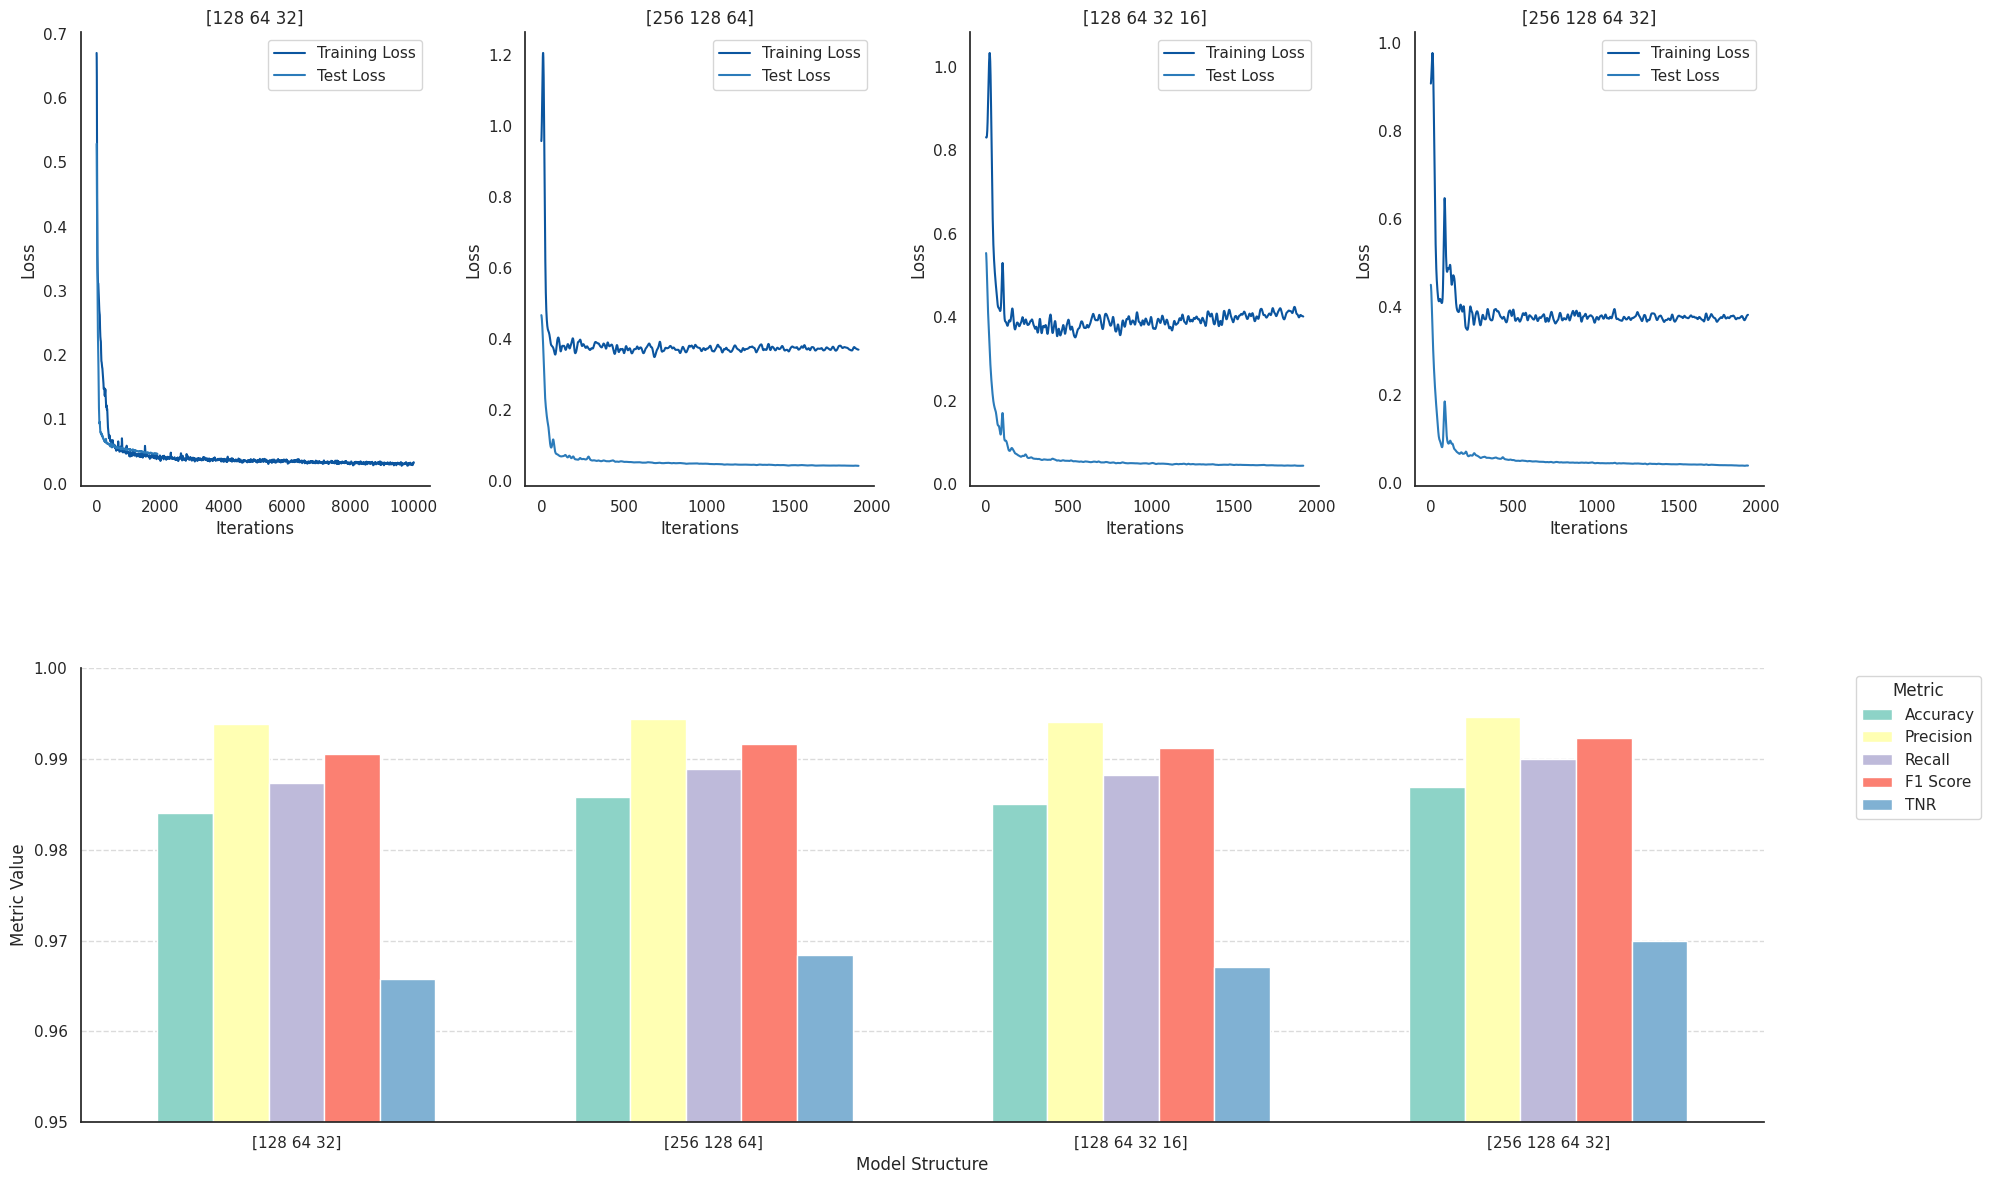

In [14]:

# 创建一个大图，使用 GridSpec 分为上下两层
plt.figure(figsize=(20, 12))  # 您可以根据需要调整图的大小
gs = GridSpec(2, 4, height_ratios=[1, 1])  # 2 行 4 列，调整高度比例

sns.set_theme(style="whitegrid", palette="Blues_r", color_codes=True)
sns.set_style("white")

ax1 = plt.subplot(gs[0, 0])
sns.lineplot(data=train_loss1_smooth, label="Training Loss", ax=ax1)
sns.lineplot(data=test_loss1_smooth, label="Test Loss", ax=ax1)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
ax1.set_title("[128 64 32]")
ax1.legend()

ax2 = plt.subplot(gs[0, 1])
sns.lineplot(data=train_loss2_smooth, label="Training Loss", ax=ax2)
sns.lineplot(data=test_loss2_smooth, label="Test Loss", ax=ax2)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")
ax2.set_title("[256 128 64]")
ax2.legend()

ax3 = plt.subplot(gs[0, 2])
sns.lineplot(data=train_loss3_smooth, label="Training Loss", ax=ax3)
sns.lineplot(data=test_loss3_smooth, label="Test Loss", ax=ax3)
ax3.set_xlabel("Iterations")
ax3.set_ylabel("Loss")
ax3.set_title("[128 64 32 16]")
ax3.legend()

ax4 = plt.subplot(gs[0, 3])
sns.lineplot(data=train_loss4_smooth, label="Training Loss", ax=ax4)
sns.lineplot(data=test_loss4_smooth, label="Test Loss", ax=ax4)
ax4.set_xlabel("Iterations")
ax4.set_ylabel("Loss")
ax4.set_title("[256 128 64 32]")
ax4.legend()

sns.set_theme(style="whitegrid", palette="Set3", color_codes=True)
sns.set_style("white")

n_metrics = len(metrics)
n_models = len(model_names)

# 定义柱宽和组间间隔
bar_width = 0.8  # 每个柱的宽度
gap_size = 2     # 组间的间隔大小，可根据需要调整

# 计算每个模型组的总宽度，包括间隔
group_width = n_metrics * bar_width + gap_size

positions = []
tick_positions = []
tick_labels = []

for i, model in enumerate(model_names):
    group_start = i * group_width
    for j in range(n_metrics):
        positions.append(group_start + j * bar_width)
    # 模型名称的刻度位置在组的中间
    tick_positions.append(group_start + (n_metrics * bar_width - bar_width) / 2)
    tick_labels.append(model)

# 将位置添加到 DataFrame
df['Position'] = positions

# 为每个指标分配颜色
colors = sns.color_palette("Set3", n_colors=n_metrics)

# 在指定的子图中绘制柱状图
ax_bar = plt.subplot(gs[1, :])  # 占据第二行的全部四列

for idx, metric in enumerate(metrics):
    subset = df[df['Metric'] == metric]
    ax_bar.bar(subset['Position'], subset['Value'], width=bar_width, color=colors[idx], label=metric)

# 设置 x 轴刻度和标签
ax_bar.set_xticks(tick_positions)
ax_bar.set_xticklabels(tick_labels)

# 设置轴标签和标题
ax_bar.set_xlabel('Model Structure')
ax_bar.set_ylabel('Metric Value')
# ax_bar.set_title('Comparison of Metrics Across Different Model Structures')

# 设置 y 轴范围
ax_bar.set_ylim(0.95, 1)

# 添加图例
ax_bar.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

# 显示网格
ax_bar.grid(True, axis='y', linestyle='--', alpha=0.7)

# 去除顶部和右侧边框
sns.despine()

# 调整布局以避免重叠
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # 调整上下子图间的间距

# 显示图像
plt.show()

In [25]:
lr_1 = "./metrics/lr_0.01.tfevents"
lr_2 = "./metrics/lr_0.001.tfevents"

steps_accuracy_lr1, accuracy_lr1 = extract_scalar_from_event(lr_1, "test accuracy")
steps_accuracy_lr2, accuracy_lr2 = extract_scalar_from_event(lr_2, "test accuracy")

steps_precision_lr1, precision_lr1 = extract_scalar_from_event(lr_1, "test precision")
steps_precision_lr2, precision_lr2 = extract_scalar_from_event(lr_2, "test precision")

steps_recall_lr1, recall_lr1 = extract_scalar_from_event(lr_1, "test recall")
steps_recall_lr2, recall_lr2 = extract_scalar_from_event(lr_2, "test recall")

steps_f1_lr1, f1_lr1 = extract_scalar_from_event(lr_1, "test f1 score")
steps_f1_lr2, f1_lr2 = extract_scalar_from_event(lr_2, "test f1 score")

steps_fpr_lr1, fpr_lr1 = extract_scalar_from_event(lr_1, "test FPR")
steps_fpr_lr2, fpr_lr2 = extract_scalar_from_event(lr_2, "test FPR")

steps_tnr_lr1, tnr_lr1 = extract_scalar_from_event(lr_1, "test TNR")
steps_tnr_lr2, tnr_lr2 = extract_scalar_from_event(lr_2, "test TNR")

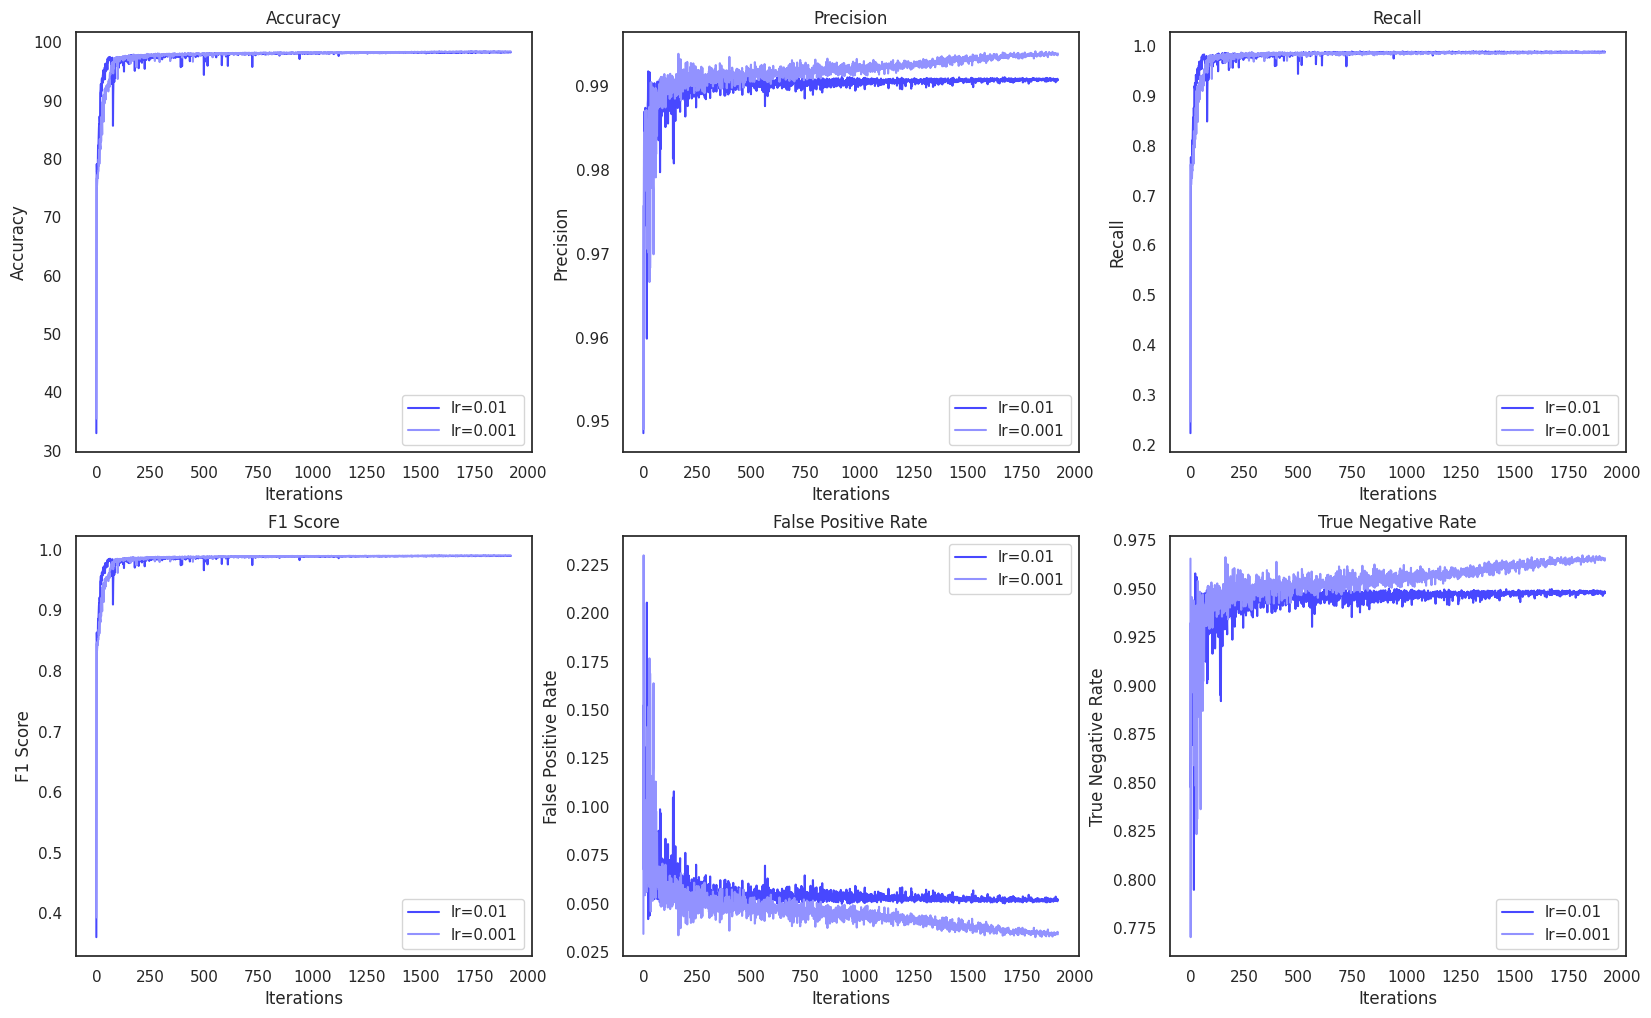

In [30]:
# 用seaborn 绘制这6个指标变化的对比图，分为两行三列
plt.figure(figsize=(20, 12))
gs = GridSpec(2, 3, height_ratios=[1, 1])  # 2 行 3 列，调整高度比例

# 设置科研配色
sns.set_theme(style="whitegrid", palette="bwr", color_codes=True)
sns.set_style("white")

# 绘制第一个图：Accuracy
ax1 = plt.subplot(gs[0, 0])
sns.lineplot(data=accuracy_lr1, label="lr=0.01", ax=ax1)
sns.lineplot(data=accuracy_lr2, label="lr=0.001", ax=ax1)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy")
ax1.legend()

# 绘制第二个图：Precision
ax2 = plt.subplot(gs[0, 1])
sns.lineplot(data=precision_lr1, label="lr=0.01", ax=ax2)
sns.lineplot(data=precision_lr2, label="lr=0.001", ax=ax2)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Precision")
ax2.set_title("Precision")
ax2.legend()

# 绘制第三个图：Recall
ax3 = plt.subplot(gs[0, 2])
sns.lineplot(data=recall_lr1, label="lr=0.01", ax=ax3)
sns.lineplot(data=recall_lr2, label="lr=0.001", ax=ax3)
ax3.set_xlabel("Iterations")
ax3.set_ylabel("Recall")
ax3.set_title("Recall")
ax3.legend()

# 绘制第四个图：F1 Score
ax4 = plt.subplot(gs[1, 0])
sns.lineplot(data=f1_lr1, label="lr=0.01", ax=ax4)
sns.lineplot(data=f1_lr2, label="lr=0.001", ax=ax4)
ax4.set_xlabel("Iterations")
ax4.set_ylabel("F1 Score")
ax4.set_title("F1 Score")
ax4.legend()

# 绘制第五个图：False Positive Rate
ax5 = plt.subplot(gs[1, 1])
sns.lineplot(data=fpr_lr1, label="lr=0.01", ax=ax5)
sns.lineplot(data=fpr_lr2, label="lr=0.001", ax=ax5)
ax5.set_xlabel("Iterations")
ax5.set_ylabel("False Positive Rate")
ax5.set_title("False Positive Rate")
ax5.legend()

# 绘制第六个图：True Negative Rate
ax6 = plt.subplot(gs[1, 2])
sns.lineplot(data=tnr_lr1, label="lr=0.01", ax=ax6)
sns.lineplot(data=tnr_lr2, label="lr=0.001", ax=ax6)
ax6.set_xlabel("Iterations")
ax6.set_ylabel("True Negative Rate")
ax6.set_title("True Negative Rate")
ax6.legend()